In [1]:
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from pyro.infer.util import torch_item
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal as Normal_torch

# python
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread
import math
import pandas as pd

# pyro
import pyro
from pyro.distributions import Normal, Categorical, MultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
import pyro.poutine as poutine
from pyro.contrib.autoguide import AutoDiagonalNormal

In [12]:
batch_size = 32
resize = 32
epoch = 20
lr = 0.0001
weight_decay = 0.0005
num_samples = 10

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

transform_test = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

In [4]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True, transform=transform_train),batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transform_test),batch_size=batch_size, shuffle=True)

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Processing...
Done!


In [5]:
def learning_rate(init, epoch):
    optim_factor = 0
    if(epoch > 160):
        optim_factor = 3
    elif(epoch > 120):
        optim_factor = 2
    elif(epoch > 60):
        optim_factor = 1

    return init*math.pow(0.2, optim_factor)

In [6]:
class LeNet(nn.Module):
    def __init__(self, num_classes, inputs=1):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(inputs, 6, 5, stride=1, bias=False)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1, bias=False)
        self.fc1 = nn.Linear(16*5*5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, num_classes, bias=False)

    def forward(self, x):
        out = F.max_pool2d(F.softplus(self.conv1(x)), 2)
        out = F.max_pool2d(F.softplus(self.conv2(out)), 2)
        out = out.view(out.size(0), -1)
        out = F.softplus(self.fc1(out))
        out = F.softplus(self.fc2(out))
        out = self.fc3(out)
        return out

In [7]:
class Bayesian(nn.Module):
    def __init__(self):
        super(Bayesian, self).__init__()
        self.net = LeNet(10, 1)
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def normal_prior(self,name, params):
        mu_param = pyro.param('{}_mu'.format(name), torch.randn_like(params))
        sigma_param = F.softplus(pyro.param('{}_sigma'.format(name), torch.randn_like(params)))
        prior = Normal(loc=mu_param, scale=sigma_param)
        return prior
    
    def mean_field_norm_prior(self, name, params, eps=10e-7):
        loc_init = pyro.param('{}_mu'.format(name), torch.normal(mean=torch.zeros_like(params), std=torch.mul(torch.ones_like(params), 0.1)))
        untransformed_scale_init = pyro.param('{}_sigma'.format(name), torch.normal(mean=torch.ones_like(params)*(-3), std=torch.mul(torch.ones_like(params), 0.1)))
        sigma = eps + F.softplus(untransformed_scale_init)
        dist = Normal(loc=loc_init, scale=sigma)
        return dist

    def fixed_normal_prior(self, params):
        dist = Normal(loc=torch.zeros_like(params), scale=torch.ones_like(params))
        return dist
    
    def model(self, x, y):
        conv1w_prior = self.fixed_normal_prior(self.net.conv1.weight)
        conv2w_prior = self.fixed_normal_prior(self.net.conv2.weight)
        fc1w_prior = self.fixed_normal_prior(self.net.fc1.weight)
        fc2w_prior = self.fixed_normal_prior(self.net.fc2.weight)
        fc3w_prior = self.fixed_normal_prior(self.net.fc3.weight)
        
        priors = {
            'conv1.weight':conv1w_prior,
            'conv2.weight':conv2w_prior, 
            'fc1.weight': fc1w_prior,
            'fc2.weight':fc2w_prior,
            'fc3.weight':fc3w_prior
        }
        
        # lift module parameters to random variables sampled from the priors
        lifted_module = pyro.random_module("module", self.net, priors)
        
        # sample a classifier
        lifted_reg_model = lifted_module()
        
        p_hat = self.log_softmax(lifted_reg_model(x))
        
        with pyro.plate('observe_data'):
            pyro.sample("obs", Categorical(logits=p_hat), obs=y)
    
    def guide(self, x, y):
        conv1w_prior = self.mean_field_norm_prior('conv1w',self.net.conv1.weight)
        conv2w_prior = self.mean_field_norm_prior('conv2w',self.net.conv2.weight)
        fc1w_prior = self.mean_field_norm_prior('fc1w',self.net.fc1.weight)
        fc2w_prior = self.mean_field_norm_prior('fc2w', self.net.fc2.weight)
        fc3w_prior = self.mean_field_norm_prior('fc3w',self.net.fc3.weight)
        
        priors = {
            'conv1.weight':conv1w_prior,
            'conv2.weight':conv2w_prior, 
            'fc1.weight': fc1w_prior,
            'fc2.weight':fc2w_prior,
            'fc3.weight':fc3w_prior
        }
        lifted_module = pyro.random_module("module", self.net, priors)
        return lifted_module()

In [8]:
net = Bayesian()
net.cuda()

Bayesian(
  (net): LeNet(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (fc1): Linear(in_features=400, out_features=120, bias=False)
    (fc2): Linear(in_features=120, out_features=84, bias=False)
    (fc3): Linear(in_features=84, out_features=10, bias=False)
  )
  (log_softmax): LogSoftmax()
)

In [9]:
def simple_elbo_kl_annealing(model, guide, *args, **kwargs):
    # get the annealing factor and latents to anneal from the keyword
    # arguments passed to the model and guide
    annealing_factor = kwargs.pop('annealing_factor', 1.0)
    # run the guide and replay the model against the guide
    guide_trace = poutine.trace(guide).get_trace(*args, **kwargs)
    model_trace = poutine.trace(
        poutine.replay(model, trace=guide_trace)).get_trace(*args, **kwargs)

    elbo = 0.0
    # loop through all the sample sites in the model and guide trace and
    # construct the loss; note that we scale all the log probabilities of
    # samples sites in `latents_to_anneal` by the factor `annealing_factor`
    for name, site in model_trace.nodes.items():
        if site["type"] == "sample":
            factor = annealing_factor if site["name"].split('$$$')[0] in ['module'] else 1.0
            elbo = elbo + factor * site["fn"].log_prob(site["value"]).sum()
    for name, site in guide_trace.nodes.items():
        if site["type"] == "sample":
            factor = annealing_factor if site["name"].split('$$$')[0] in ['module'] else 1.0
            elbo = elbo - factor * site["fn"].log_prob(site["value"]).sum()
    return -elbo

In [10]:
pyro.clear_param_store()
optim = Adam({"lr": 0.01})
svi = SVI(net.model, net.guide, optim, loss=simple_elbo_kl_annealing)

In [11]:
def predict(x, net):
    sampled_models = net.guide(None, None)
    yhats = sampled_models(x).data
    return yhats

def train(e, svi, loader):
    train_loss = 0
    correct = 0
    total = 0
    m = math.ceil(len(loader.dataset)/batch_size)
    svi.optim = Adam({"lr": learning_rate(lr, e), 'weight_decay': weight_decay})
    
    for batch_idx, data in enumerate(loader):
        inputs_value = data[0]
        targets = data[1]
        
        x = inputs_value.view(-1, 1, resize, resize).repeat(num_samples, 1, 1, 1).cuda()
        y = targets.repeat(num_samples).cuda()
        
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
        
        x, y = Variable(x), Variable(y)
        
        loss =svi.step(x, y, annealing_factor=beta)
        train_loss += loss
        
        predicted = torch.argmax(predict(x, svi), dim=1)
        correct += predicted.eq(y.data).cpu().sum().item()
        total += targets.size(0)
        
#         print('|Epoch:{}/{}|Iter:{}/{}|Loss:{}|Acc:{}'.format(
#             e, epoch, batch_idx+1, (len(loader.dataset.train_data)//batch_size)+1, loss, (100*correct/total)/num_samples))
    print('================>Epoch: ',e, 'Loss: ', train_loss/(len(loader.dataset.train_data)*num_samples), 'Acc: ', (100*correct/total)/num_samples) 

In [13]:
for e in range(epoch):
    train(e, svi, train_loader)

================>Epoch:  0 Loss:  2.0367423130289715 Acc:  36.66166666666667
================>Epoch:  1 Loss:  0.8245115194574992 Acc:  81.86
================>Epoch:  2 Loss:  0.5939065231974919 Acc:  89.50166666666667
================>Epoch:  3 Loss:  0.4953631006717682 Acc:  92.71166666666667
================>Epoch:  4 Loss:  0.4418179518679778 Acc:  94.495
================>Epoch:  5 Loss:  0.40888828094681107 Acc:  95.40166666666667
================>Epoch:  6 Loss:  0.3894409182097018 Acc:  96.06
================>Epoch:  7 Loss:  0.3723757892141243 Acc:  96.42333333333333
================>Epoch:  8 Loss:  0.3590844763955474 Acc:  96.78333333333333
================>Epoch:  9 Loss:  0.3499815596949309 Acc:  97.12333333333333
================>Epoch:  10 Loss:  0.3425780458386739 Acc:  97.285
================>Epoch:  11 Loss:  0.3352619662763675 Acc:  97.575
================>Epoch:  12 Loss:  0.3304026311603685 Acc:  97.71333333333334
================>Epoch:  13 Loss:  0.323893468662177

# Result Analysis

## Test Accuracy

In [17]:
def predict(x, T, net):
    sampled_models = [net.guide(None, None) for _ in range(T)]
    yhats = [model(x).data for model in sampled_models]
    yhats = torch.stack(yhats, dim=1)
    mean = torch.mean(yhats, 1)
    return np.argmax(mean.cpu().numpy(), axis=1)

def evaluate(T, loader, net):
    correct = 0
    total = 0
    for j, data in enumerate(loader):
        images, labels = data
        predicted = predict(images.view(-1, 1, 32, 32).cuda(), T, net)
        total += labels.size(0)
        correct += (predicted == np.array(labels)).sum().item()
    return (100 * correct / total)

In [18]:
acc = evaluate(10, test_loader, net)
print('T: ', 10, 'Acc: ', acc)

T:  10 Acc:  99.0


## accuracy remove samples with all probability less than 0.5

In [23]:
def predict(x, T, net):
    sampled_models = [net.guide(None, None) for _ in range(T)]
    yhats = [model(x).data for model in sampled_models]
    yhats = F.softmax(torch.stack(yhats, dim=1), dim=2)
    mean = torch.mean(yhats, 1)
    return np.argmax(mean.cpu().numpy(), axis=1), mean.cpu().numpy()

def evaluate(T, loader, net, threshold=0.2):
    correct = 0
    total = 0
    all_cnt = 0
    for j, data in enumerate(loader):
        images, labels = data
        predicted, mean_prob = predict(images.view(-1, 1, 32, 32).cuda(), T, net)
        confidence = np.max(mean_prob, axis=1)
        idx = [idx for idx in range(confidence.shape[0]) if confidence[idx]>threshold]
        all_cnt += len(labels)
        total += len(idx)
        correct += (predicted[idx] == np.array(labels)[idx]).sum().item()
    return (100 * correct / total), all_cnt-total, total/all_cnt

### threshold = 0.5

In [24]:
acc, skip, ratio = evaluate(10, test_loader, net, threshold=0.5)
print('accuracy is: ', acc)
print('number of samples skipped :', skip)
print('raio (able to predict/all sample):', ratio)

accuracy is:  99.17521625427479
number of samples skipped : 58
raio (able to predict/all sample): 0.9942


In [25]:
acc, skip, ratio = evaluate(20, test_loader, net,threshold=0.5)
print('accuracy is: ', acc)
print('number of samples skipped :', skip)
print('raio (able to predict/all sample):', ratio)

accuracy is:  99.2049914461105
number of samples skipped : 63
raio (able to predict/all sample): 0.9937


## threshold = 0.6

In [26]:
acc, skip, ratio = evaluate(10, test_loader, net,threshold=0.6)
print('accuracy is: ', acc)
print('number of samples skipped :', skip)
print('raio (able to predict/all sample):', ratio)

accuracy is:  99.45294296423867
number of samples skipped : 129
raio (able to predict/all sample): 0.9871


In [27]:
acc, skip, ratio = evaluate(20, test_loader, net,threshold=0.6)
print('accuracy is: ', acc)
print('number of samples skipped :', skip)
print('raio (able to predict/all sample):', ratio)

accuracy is:  99.4630192502533
number of samples skipped : 130
raio (able to predict/all sample): 0.987


## Uncertainty Estimation

In [28]:
def predict(x, T, net):
    sampled_models = [net.guide(None, None) for _ in range(T)]
    yhats = [model(x).data for model in sampled_models]
    yhats = F.softmax(torch.stack(yhats, dim=1), dim=2)
    mean = torch.mean(yhats, 1).cpu().numpy()
    
    # uncertainty
    # yhats [batch * 10 * 10]
    p_hat = yhats.cpu().numpy()
    aleatoric = np.mean(p_hat*(1-p_hat), axis=1) # batch * 10
    epistemic = np.mean(p_hat**2, axis=1) - np.mean(p_hat, axis=1)**2 # batch * 10
    return np.argmax(mean, axis=1), mean, aleatoric, epistemic

def evaluate(T, loader, net,threshold=0.2):
    correct = 0
    total = 0
    all_cnt = 0
    total_alea_thresh = 0
    total_epis_thresh = 0
    for j, data in enumerate(loader):
        images, labels = data
        predicted, mean_prob, aleatoric, epistemic = predict(images.view(-1, 1, 32, 32).cuda(), T, net)
        confidence = np.max(mean_prob, axis=1)
        idx = [idx for idx in range(confidence.shape[0]) if confidence[idx]>threshold]
        all_cnt += len(labels)
        total += len(idx)
        correct += (predicted[idx] == np.array(labels)[idx]).sum().item()
        
        # uncertainty for the best choice
        total_alea_thresh += np.choose(predicted, aleatoric.T)[idx].sum().item()
        total_epis_thresh += np.choose(predicted, epistemic.T)[idx].sum().item()
    return (100 * correct / total), all_cnt-total, total/all_cnt, total_alea_thresh/total, total_epis_thresh/total

## threshold = 0.5

In [29]:
acc, skip, ratio, mean_alea, mean_epis = evaluate(10, test_loader, net,threshold=0.5)
print('accuracy is: ', acc)
print('number of samples skipped :', skip)
print('raio (able to predict/all sample):', ratio)
print('mean epistemic:', mean_epis)
print('mean aleaotoric:', mean_alea)

accuracy is:  99.16515791591229
number of samples skipped : 58
raio (able to predict/all sample): 0.9942
mean epistemic: 0.004229519091317218
mean aleaotoric: 0.009353471910526661


In [30]:
acc, skip, ratio, mean_alea, mean_epis = evaluate(20, test_loader, net,threshold=0.5)
print('accuracy is: ', acc)
print('number of samples skipped :', skip)
print('raio (able to predict/all sample):', ratio)
print('mean epistemic:', mean_epis)
print('mean aleaotoric:', mean_alea)

accuracy is:  99.21481779746325
number of samples skipped : 66
raio (able to predict/all sample): 0.9934
mean epistemic: 0.004220060414655458
mean aleaotoric: 0.009211155619507515


## threshold = 0.6

In [31]:
acc, skip, ratio, mean_alea, mean_epis = evaluate(10, test_loader, net,threshold=0.6)
print('accuracy is: ', acc)
print('number of samples skipped :', skip)
print('raio (able to predict/all sample):', ratio)
print('mean epistemic:', mean_epis)
print('mean aleaotoric:', mean_alea)

accuracy is:  99.4224924012158
number of samples skipped : 130
raio (able to predict/all sample): 0.987
mean epistemic: 0.0033791172226632377
mean aleaotoric: 0.008370493447904408


In [32]:
acc, skip, ratio, mean_alea, mean_epis = evaluate(20, test_loader, net,threshold=0.6)
print('accuracy is: ', acc)
print('number of samples skipped :', skip)
print('raio (able to predict/all sample):', ratio)
print('mean epistemic:', mean_epis)
print('mean aleaotoric:', mean_alea)

accuracy is:  99.45316455696202
number of samples skipped : 125
raio (able to predict/all sample): 0.9875
mean epistemic: 0.003713118960585775
mean aleaotoric: 0.008435791034864474


## analyse the sample with confidence over 0.6 but prediction is wrong

In [66]:
def predict(x, T, net):
    sampled_models = [net.guide(None, None) for _ in range(T)]
    yhats = [model(x).data for model in sampled_models]
    yhats = F.softmax(torch.stack(yhats, dim=1), dim=2)
    mean = torch.mean(yhats, 1).cpu().numpy()
    
    # uncertainty
    # yhats [batch * 10 * 10]
    p_hat = yhats.cpu().numpy()
    aleatoric = np.mean(p_hat*(1-p_hat), axis=1) # batch * 10
    epistemic = np.mean(p_hat**2, axis=1) - np.mean(p_hat, axis=1)**2 # batch * 10
    return np.argmax(mean, axis=1), mean, aleatoric, epistemic

def evaluate(T, loader, net, threshold=0.2):
    cnt = 0
    for j, data in enumerate(loader):
        images, labels = data
        predicted, mean_prob, aleatoric, epistemic = predict(images.view(-1, 1, 32, 32).cuda(), T, net)
        confidence = np.max(mean_prob, axis=1)
        idx = [idx for idx in range(confidence.shape[0]) if confidence[idx]>threshold]
        correct = (predicted[idx] == np.array(labels)[idx])
        wrong_idx = [i for i in range(len(correct)) if correct[i] == False]
        usable_idx = np.array(idx)[wrong_idx]
        if len(wrong_idx)>0:
            cnt += 1
            if cnt>1:
                return images[usable_idx], labels[usable_idx], mean_prob[usable_idx], aleatoric[usable_idx], epistemic[usable_idx]

In [67]:
image, label, prob, alea, epis = evaluate(10, test_loader, net, threshold=0.6)

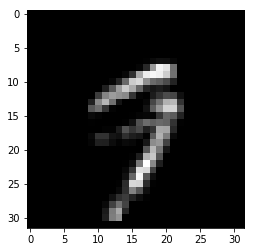

confidence:
[7.2027780e-03 1.6286856e-02 8.3926478e-03 2.5786329e-02 3.1992984e-03
 1.5347804e-02 6.3475961e-04 7.5265104e-01 7.3810192e-03 1.6311747e-01]
label:
9
prediction
7
alea 
[0.00710575 0.01567226 0.00820803 0.02437887 0.00317253 0.01486904
 0.00063351 0.17424259 0.00725646 0.12619355]
epis
[4.51466985e-05 3.49340407e-04 1.14174924e-04 7.42525328e-04
 1.65370111e-05 2.43206741e-04 8.46871671e-07 1.19249225e-02
 7.00813398e-05 1.03166029e-02]


In [70]:
num = 0
plt.figure()
plt.imshow(image[num].numpy().squeeze(), cmap='gray')
plt.show()
plt.close()
print('confidence:')
print(prob[num])
print('label:')
print(label[num].numpy())
print('prediction')
print(np.argmax(prob[num]))
print('alea ')
print(alea[num])
print('epis')
print(epis[num])

## Expected Calibration Error (ECE)

In [71]:
class ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, softmaxes, labels):
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

In [72]:
ece = ECELoss(n_bins = 10)

In [73]:
def predict(x, T, net):
    sampled_models = [net.guide(None, None) for _ in range(T)]
    yhats = [F.softmax(model(x).data, dim=1) for model in sampled_models]
    yhats = torch.stack(yhats, dim=1)
    mean = torch.mean(yhats, 1)
    return mean

def evaluate(T, loader, net):
    prob_list = []
    label_list = []
    for j, data in enumerate(loader):
        images, labels = data
        predicted = predict(images.view(-1, 1, 32, 32).cuda(), T, net)
        label_list.extend(labels)
        prob_list.append(predicted)
    label_list = torch.stack(label_list, dim=0).view(-1).cpu()
    prob_list = torch.cat(prob_list, dim=0).cpu()  
    return ece.forward(prob_list, label_list)

In [74]:
ece_loss = evaluate(10, test_loader, net)
print('ece_loss:', str(ece_loss.item()))

ece_loss: 0.009982832707464695


# Reliability Diagram

In [75]:
class ReliabilityDiagram(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=10):
        """
        n_bins (int): number of confidence interval bins
        """
        super(ReliabilityDiagram, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, softmaxes, labels):
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        x = []
        y = []
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                x.append(avg_confidence_in_bin)
                y.append(accuracy_in_bin)
        return torch.stack(x, dim=0).view(-1).cpu().numpy(), torch.stack(y, dim=0).view(-1).cpu().numpy()

In [76]:
rd = ReliabilityDiagram(n_bins=10)

In [78]:
def predict(x, T, net):
    sampled_models = [net.guide(None, None) for _ in range(T)]
    yhats = [F.softmax(model(x).data, dim=1) for model in sampled_models]
    yhats = torch.stack(yhats, dim=1)
    mean = torch.mean(yhats, 1)
    return mean

def evaluate(T, loader, net):
    prob_list = []
    label_list = []
    for j, data in enumerate(loader):
        images, labels = data
        predicted = predict(images.view(-1, 1, 32, 32).cuda(), T, net)
        label_list.extend(labels)
        prob_list.append(predicted)
    label_list = torch.stack(label_list, dim=0).view(-1).cpu()
    prob_list = torch.cat(prob_list, dim=0).cpu()  
    return label_list, prob_list

In [79]:
label, prob = evaluate(10, test_loader, net)
x,y = rd(prob, label)

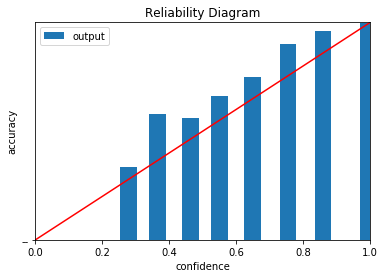

In [80]:
plt.figure()
plt.bar(x=x, height=y, width=0.05, label='output')
plt.plot(np.linspace(0, 1, 11), np.linspace(0, 1, 11), 'r', '--')
plt.xlabel('confidence')
plt.ylabel('accuracy')
plt.title('Reliability Diagram')
plt.xlim(0, 1)
plt.ylim(0,1)
plt.legend()
plt.show()
plt.close()

# What Model Don't Know

In [85]:
test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('fashion-mnist-data/', train=False, download=True, transform=transform_train
                       ),
        batch_size=128, shuffle=True)

In [86]:
def predict(x, T, net):
    sampled_models = [net.guide(None, None) for _ in range(T)]
    yhats = [model(x).data for model in sampled_models]
    yhats = F.softmax(torch.stack(yhats, dim=1), dim=2)
    mean = torch.mean(yhats, 1).cpu().numpy()
    
    # uncertainty
    # yhats [batch * 10 * 10]
    p_hat = yhats.cpu().numpy()
    aleatoric = np.mean(p_hat*(1-p_hat), axis=1) # batch * 10
    epistemic = np.mean(p_hat**2, axis=1) - np.mean(p_hat, axis=1)**2 # batch * 10
    return np.argmax(mean, axis=1), mean, aleatoric, epistemic

def evaluate(T, loader, net,threshold=0.2):
    entropy = 0
    total = 0
    all_cnt = 0
    total_alea_thresh = 0
    total_epis_thresh = 0
    entropy = np.array([])
    for j, data in enumerate(loader):
        images, labels = data
        predicted, mean_prob, aleatoric, epistemic = predict(images.view(-1, 1, 32, 32).cuda(), T, net)
        confidence = np.max(mean_prob, axis=1)
        idx = [idx for idx in range(confidence.shape[0]) if confidence[idx]>threshold]
        all_cnt += len(labels)
        total += len(idx)
        entropy = np.concatenate([entropy, confidence])
        # uncertainty for the best choice
        total_alea_thresh += np.choose(predicted, aleatoric.T).sum().item()
        total_epis_thresh += np.choose(predicted, epistemic.T).sum().item()
    entropy = -np.log(entropy)
    return all_cnt-total, total/all_cnt, total_alea_thresh/total, total_epis_thresh/total, entropy

In [87]:
skip, ratio, alea_mean, epis_mean, entropy = evaluate(10, test_loader, net,threshold=0.5)
print('number of sample skipped ', skip)
print('predict ratio ',ratio)
print('mean alea ', alea_mean)
print('mean epis ', epis_mean)

number of sample skipped  4833
predict ratio  0.5167
mean alea  0.3465861307944831
mean epis  0.0587088311343768


In [89]:
entropy_cnt = pd.Series(entropy).value_counts().sort_index()
cumulative = np.cumsum(entropy_cnt.values)

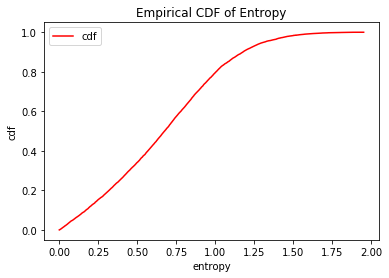

In [90]:
plt.figure()
plt.plot(entropy_cnt.index, cumulative/cumulative[-1], 'r', label='cdf')
plt.xlabel('entropy')
plt.ylabel('cdf')
plt.title('Empirical CDF of Entropy')
plt.legend()
plt.show()